In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import glob
from netCDF4 import Dataset
import os

/home/lmar/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/lmar/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/tmp/ipykernel_5481/2430711590.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import sys
sys.path.append('..')
from MultiLineSubPlotter import MultiLineSubplotter, VerticalPlotter, HorizontalPlotter
from Interpolator import Interpolator

### Importing the observation data

Our goal here is to get the kestrel `.csv` file into a pandas dataframe, with the correct formatting.

Below, we first read the file into a dataframe, indicating that the header is on lines 8 and 9 of the file and that the column values are separated by a comma. 

In [3]:
path = '/data/shared_data/observations/kestrel/WEATHER - 2434489_2023-10-11 08_50_00.csv'

kes_data = pd.read_csv(path, delimiter=',', header=[8,9])

Next, we take each time value, which is initially a string, and convert it to a date time object. This will enable us to plot more powerfully and have more control over the data.

This is how the first ten times look prior to conversion:

In [4]:
kes_data['Time'].to_numpy().flatten().tolist()[:10]

['2023-10-09 12:44:00',
 '2023-10-09 12:45:00',
 '2023-10-09 12:46:00',
 '2023-10-09 12:47:00',
 '2023-10-09 12:48:00',
 '2023-10-09 12:49:00',
 '2023-10-09 12:50:00',
 '2023-10-09 12:51:00',
 '2023-10-09 12:52:00',
 '2023-10-09 12:53:00']

Note how we have used `kes_data['Time'].to_numpy().flatten().tolist()`. What is happening here?

The cell below uses a python list comprehension , but written out as a for loop it would look like:
```
converted_times = []

for d in  kes_data['Time'].to_numpy().flatten().tolist():
    converted_time = dt.datetime.strptime(d, '%Y-%m-%d %H:%M:%S')
    converted_times.append(converted_time)
  
kestrel_data['Time'] = converted_times
```

In [5]:
kes_data['Time'] = [dt.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in kes_data['Time'].to_numpy().flatten().tolist()]

Let's look at our formatted data.

In [6]:
kes_data

,Time,Temp,Wet Bulb Temp.,Rel. Hum.,Baro.,Altitude,Station P.,Wind Speed,Heat Index,Dew Point,Dens. Alt.,Crosswind,Headwind,Mag. Dir.,True Dir.,Wind Chill
,yyyy-MM-dd hh:mm:ss,Celsius,Celsius,%,mb,Meters,mb,m/s,Celsius,Celsius,Meters,m/s,m/s,Degrees,Degrees,Celsius
0,2023-10-09 12:44:00,22.4,18.0,66.0,1012.4,6,1012.4,0.4,22.5,15.7,341,***,***,***,***,22.3
1,2023-10-09 12:45:00,22.3,18.1,66.6,1012.7,2,1012.8,0.3,22.5,15.8,334,***,***,***,***,22.2
2,2023-10-09 12:46:00,22.9,18.4,65.4,1012.7,2,1012.8,0.7,23.0,16.0,355,***,***,***,***,22.8
3,2023-10-09 12:47:00,22.0,17.9,67.3,1012.7,4,1012.6,1.1,22.3,15.7,326,***,***,***,***,22.0
4,2023-10-09 12:48:00,22.2,18.1,67.0,1012.7,4,1012.7,0.5,22.5,15.8,333,***,***,***,***,22.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642,2023-10-11 08:46:00,22.4,16.7,56.5,1000.7,102,1000.8,0.0,22.1,13.3,452,0.0,0.0,10,10,22.3
2643,2023-10-11 08:47:00,22.4,16.7,56.5,1000.7,102,1000.8,0.0,22.2,13.3,451,0.0,0.0,10,10,22.4
2644,2023-10-11 08:48:00,22.4,16.7,56.2,1000.9,102,1000.9,0.0,22.2,13.3,450,0.0,0.0,10,11,22.4


### Functions for subsetting WRF file list

The function `wrfout_time` takes a wrfout file name (as a string) and converts the date and time contained within in to a datetime object.

In [7]:
def wrfout_time(filename):
    """
    Returns a date time object based on wrf file name
    """
    time = dt.datetime.strptime(filename.split('_',2)[2], '%Y-%m-%d_%H:%M:%S')
    return time

For example:

In [8]:
wrf_file_name = 'wrfout_d02_2024-04-13_00:00:00'
wrfout_time(wrf_file_name)

datetime.datetime(2024, 4, 13, 0, 0)

The function `wrfout_inside_time` will return a boolean dependent on whether a wrfout file represents a time between the two datetime objects `init_time` and `final_time`. 

We have set these two variables as the first and last valid times in the kestrel data.

In [9]:
# Get time bounds from Obs data
init_time = kes_data.iat[0, 0].to_pydatetime()
final_time = kes_data.iat[-1, 0].to_pydatetime()

def wrfout_inside_time(filename):
    """ 
    boolean, Filters wrfout files such that only files valid in a time range
    """
    return init_time <= wrfout_time(filename) and wrfout_time(filename) <= final_time

For example:

In [10]:
init_time, final_time, wrfout_time(wrf_file_name)

(datetime.datetime(2023, 10, 9, 12, 44),
 datetime.datetime(2023, 10, 11, 8, 50),
 datetime.datetime(2024, 4, 13, 0, 0))

In [11]:
wrfout_inside_time(wrf_file_name)

False


### Import WRF data

Here we upload the correct wrfouts by filtering using the two function shown above.


First we navigate to the desired directory - here `2023100912` is the date and hour of the forecast initiation time.

The wrf forecast run in Coordinated Universal Time (UTC). How will we need to account for this?

In [12]:
path = '/data/shared_data/model/2023100912/'
os.chdir(path)

We then use the glob module to get all files in that directory that start with the prefix `wrfout_d02` using the wildcard character `*` which is equivalent to any any string that follows our prefix. 

In [13]:
all_wrfouts = glob.glob('wrfout_d02*')
all_wrfouts[10:]

['wrfout_d02_2023-10-10_02:00:00',
 'wrfout_d02_2023-10-10_03:00:00',
 'wrfout_d02_2023-10-10_04:00:00',
 'wrfout_d02_2023-10-10_05:00:00',
 'wrfout_d02_2023-10-10_06:00:00',
 'wrfout_d02_2023-10-10_07:00:00',
 'wrfout_d02_2023-10-10_08:00:00',
 'wrfout_d02_2023-10-10_09:00:00',
 'wrfout_d02_2023-10-10_10:00:00',
 'wrfout_d02_2023-10-10_11:00:00',
 'wrfout_d02_2023-10-10_12:00:00',
 'wrfout_d02_2023-10-10_13:00:00',
 'wrfout_d02_2023-10-10_14:00:00',
 'wrfout_d02_2023-10-09_14:00:00',
 'wrfout_d02_2023-10-09_15:00:00',
 'wrfout_d02_2023-10-09_18:00:00',
 'wrfout_d02_2023-10-09_19:00:00',
 'wrfout_d02_2023-10-10_15:00:00',
 'wrfout_d02_2023-10-10_16:00:00',
 'wrfout_d02_2023-10-10_17:00:00',
 'wrfout_d02_2023-10-10_18:00:00',
 'wrfout_d02_2023-10-10_19:00:00',
 'wrfout_d02_2023-10-10_20:00:00',
 'wrfout_d02_2023-10-10_21:00:00',
 'wrfout_d02_2023-10-10_22:00:00',
 'wrfout_d02_2023-10-10_23:00:00',
 'wrfout_d02_2023-10-11_00:00:00',
 'wrfout_d02_2023-10-11_01:00:00',
 'wrfout_d02_2023-10

The filenames are sorted and then we filter them using the `wrf_inside_time` function, the read them into a list of `Dataset` objects provided by `netCDF4`

In [30]:
all_wrfouts.sort()
intime_wrfouts = [path + filename for filename in list(filter(wrfout_inside_time, all_wrfouts))]

datasets = [Dataset(wrfout, 'r') for wrfout in intime_wrfouts]

masked_array(
  data=[[[102123.836, 102126.05 , 102128.445, ..., 101115.42 ,
          101107.87 , 101100.28 ],
         [102123.62 , 102125.58 , 102128.016, ..., 101058.875,
          101054.85 , 101048.61 ],
         [102123.414, 102125.35 , 102127.945, ..., 100993.875,
          100995.69 , 100999.43 ],
         ...,
         [101270.96 , 101275.66 , 101279.71 , ..., 101690.72 ,
          101691.59 , 101691.92 ],
         [101269.3  , 101273.67 , 101277.79 , ..., 101685.92 ,
          101687.74 , 101688.8  ],
         [101268.05 , 101271.74 , 101275.6  , ..., 101681.25 ,
          101683.48 , 101685.51 ]]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

### Using wrf-python to load and interpolate our wrf data to the kestrel location

The `wrf-python` package will be used regularily throughout the course to help us process the WRF model data.

We use the function `ll_to_xy` to get the gridpoint coordinates from our latitude longitude coordinates.

We do this for two cases, `as_int` both `True`, which is the nearest gridpoint, and as `False` which returns a decimal value i.e. the exact point which is floating between grid points.

In [15]:
from wrf import getvar, ll_to_xy, ALL_TIMES

grid_ref_flt = ll_to_xy(datasets[0], 53.804602231327706, -1.5610871999035574, as_int=False)
grid_ref_int = ll_to_xy(datasets[0], 53.804602231327706, -1.5610871999035574, as_int=True)
grid_ref_flt, grid_ref_int

(<xarray.DataArray 'xy' (x_y: 2)> Size: 16B
 array([161.904447  , 104.05856499])
 Coordinates:
     latlon_coord  object 8B CoordPair(lat=53.804602231327706, lon=-1.56108719...
   * x_y           (x_y) <U1 8B 'x' 'y',
 <xarray.DataArray 'xy' (x_y: 2)> Size: 16B
 array([162, 104])
 Coordinates:
     latlon_coord  object 8B CoordPair(lat=53.804602231327706, lon=-1.56108719...
   * x_y           (x_y) <U1 8B 'x' 'y')

We create two `Interpolator` objects, one for each case of the grid reference.

### what are the implications of using interpolation???

In [16]:
interps_flt = Interpolator(grid_ref_flt[1], grid_ref_flt[0])
interps_int = Interpolator(grid_ref_int[1], grid_ref_int[0])

Now we load the desired variables using the `getvar` function from `wrf-python`: 2m temperature as `T2` (dry bulb) and 2m relative humidity as `rh2`.

These quantities are part of the standard set of diagnostics that `wrf-python` let's us access.

We can run `getvar` on a list of datasets, and use the `cat` method to create on netcdf object for the variable.

In [17]:
T2 = getvar(datasets, 'T2', timeidx=None, method='cat')
RH = getvar(datasets, 'rh2', timeidx=None, method='cat')

We now interpolate both the `T2` and `RH` data. Again we use list comprehensions, we can think of this as 'at each timestep, interpolate the two dimensional array to the given xy grid reference'.

In [18]:
T2_flt = np.array([interps_flt.interp(twodarr) for twodarr in T2.to_numpy()])-273.15
T2_int = np.array([interps_int.interp(twodarr) for twodarr in T2.to_numpy()])-273.15

RH_flt = np.array([interps_flt.interp(twodarr) for twodarr in RH.to_numpy()])
RH_int = np.array([interps_int.interp(twodarr) for twodarr in RH.to_numpy()])

RH_int

array([69.32102966, 74.21098328, 76.01914978, 78.21497345, 84.68736267,
       88.94715881, 92.07346344, 90.91184235, 92.15927887, 92.89099884,
       95.49490356, 96.79550171, 95.46625519, 92.53643799, 88.63262939,
       83.27398682, 80.19454193, 78.9300766 , 75.30188751, 71.17453766,
       68.83661652, 58.77187729, 52.01621246, 43.4196167 , 45.28322983,
       51.98373795, 57.66690063, 62.75677872, 70.07728577, 74.69117737,
       79.23622131, 84.08692169, 86.64588165, 89.52274323, 90.76152039,
       89.98697662, 89.89839935, 90.24076843, 89.06673431, 88.53178406,
       90.43584442, 90.51456451, 92.0663147 , 85.97400665])

Why have we taken `273.15` from the `T2` arrays?

### Plotting

We will plot our data using a custom class: `VerticalPlotter`, which allows us to created vertically stacked plots with an easy interface.

It requires us to create some data structures that represent what we want to plot.

At the top level we have an array (correlating to a plot) of dictionaries (corresponding to lines on that plot).

Each line dictionary will contain `x` for the x axis data, `y` for the axis data (both of which must be one dimensional arrays of the same size) and optionally a `label` for the legend, a `color`, a `linestyle` and a `marker`. 

Please see how the examples below...

In [19]:
temp_lines_all = [
    {
        'x': kes_data['Time'].to_numpy().flatten(),
        'y': kes_data['Temp'].to_numpy().flatten(),
        'label': 'Kestrel',
        'color': 'r',
        'linestyle': '-',
        'marker': ''
    },
    {
        'x': T2.coords['Time'].to_numpy(),
        'y': T2_int,
        'label': 'WRF, nearest gridpoint',
        'color': 'g',
        'linestyle': '',
        'marker': 'o'

    },
    {
        'x': T2.coords['Time'].to_numpy(),
        'y': T2_flt,
        'label': 'WRF, interpolated',
        'color': 'b',
        'linestyle': '',
        'marker': 'x'

    }
]

rh_lines_all = [
    {
        'x': kes_data['Time'].to_numpy().flatten(),
        'y': kes_data['Rel. Hum.'].to_numpy().flatten(),
        'label': 'Kestrel',
        'color': 'r',
        'linestyle': '-',
        'marker': ''
    },
    {
        'x': RH.coords['Time'].to_numpy(),
        'y': RH_int,
        'label': 'WRF, nearest gridpoint',
        'color': 'g',
        'linestyle': '',
        'marker': 'o'

    }
]

We will now initialise our `VerticalPlotter` object.


The arguments here are:
    
size of each subplot: `(20, 3)`
number of subplots: `2`,
title: `Blen.`
space between the plot: `space_between=0`

In [20]:
plot = VerticalPlotter((20, 3), 2, 'Blen.', space_between=0)

Now we call the `add_plot` method for each of our plot arrays above.

The second argument is the y axis label.

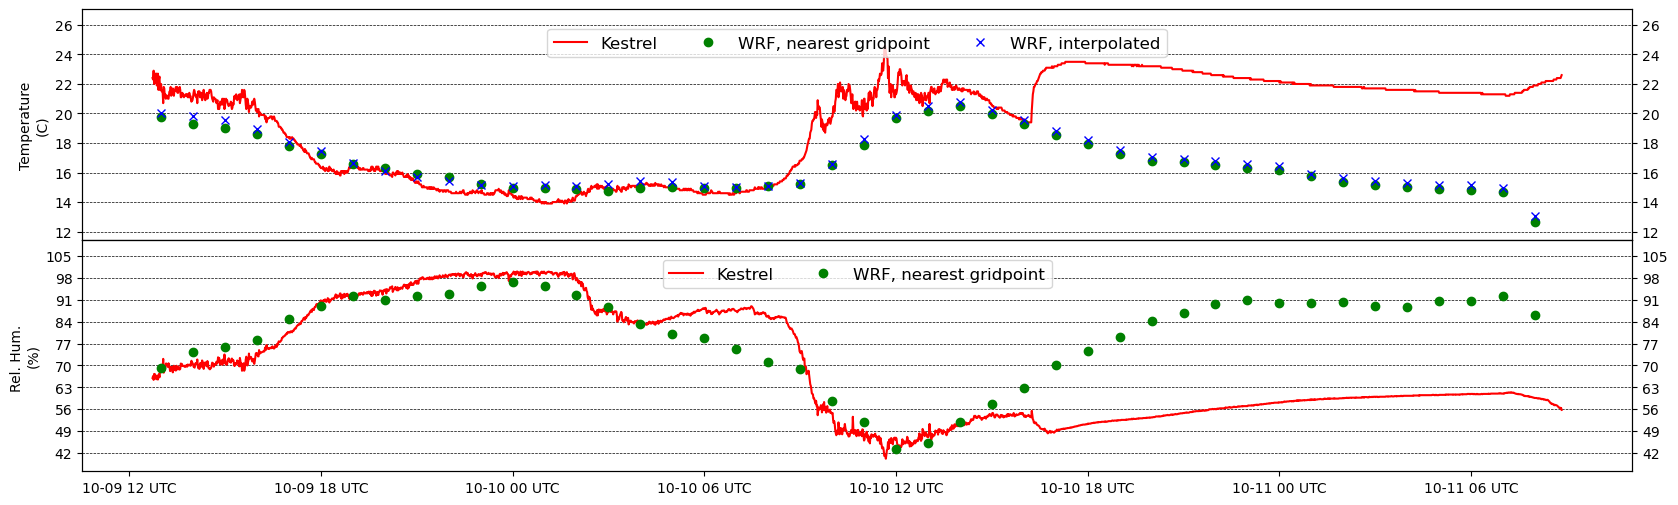

In [21]:
plot.add_plot(temp_lines_all, 'Temperature\n(C)', legend=True)
plot.add_plot(rh_lines_all, 'Rel. Hum. \n(%)', legend=True)